In [1]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks, correlate
from scipy.optimize import fsolve
from IPython.display import HTML
from tqdm import tqdm
import pickle
import matplotlib.cm as cm

# Import functions for simulation and visualisation
import visualisation as vis
from delta_hes_model import *
from analysis import *

plt.rcParams['text.usetex'] = True

plt.rcParams['text.usetex'] = True

hescolor1 = '#fdc776'  # light
hescolor2 = '#fc4e2a'  # dark
hescolor3 = '#8b1a0e'  # dark red with a warm tone

# Internal oscillator 

This code plots the figures for the dependency of the internal period on the Hes delay and the oscillatory behaviour of two Hes time delays. It first runs the simulations to collect data
for the internal oscillator with varying delay of Hes. Then this code analyses the period of these system and makes various plots for the thesis report

In [2]:
#set the lattice of the cells 
P = 2
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50
T_coupling = 0
w_coupling = 0 # no coupling strength to simulate uncoupled oscillations
w_h = 1
l = 5
n = 3

# the important parameters for this test
# T_h = 10     # delay in Hes of first cell

num_tsteps = 20000
dt = 0.2

# Run simulations for data

## Data for uncoupled internal oscillators

Hes delay ranging from 15 mins to 25 mins

In [3]:
hes_delays = np.linspace(0, 10, 11) + 15

results_uncoupled = np.zeros((len(hes_delays), num_tsteps, 2))

for i in range(len(hes_delays)):
    T_h = hes_delays[i]  # set the delay in Hes of first cell
    params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False , grad_coup = False, grad_hes_strength = 0, grad_coup_strength = 0)
    h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
    results_uncoupled[i,:,0] = h[:,0].flatten()
    results_uncoupled[i,:,1] = d[:,0].flatten()


100%|██████████| 19999/19999 [00:04<00:00, 4915.05it/s]


### Data for two specific Hes delays

Hes delays are 10 and 20 minutes

In [3]:
hes_examples = [10, 20]
results_examples= np.zeros((len(hes_examples), num_tsteps, 2))

for i in range(len(hes_examples)):
    T_h = hes_examples[i]  # set the delay in Hes of first cell
    params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False , grad_coup = False, grad_hes_strength = 0, grad_coup_strength = 0)
    h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
    results_examples[i,:,0] = h[:,0].flatten()
    results_examples[i,:,1] = m_h[:,0].flatten()

m_h_plot = np.linspace(0, 50, 100)
h_plot = np.linspace(0, 300, 100)

# Calculate nullclines
h_null_plot, m_h_null_plot = nullclines_Hes(m_h_plot, h_plot, p_h, l, gamma_h, gamma_m)

100%|██████████| 19999/19999 [00:02<00:00, 7415.25it/s]


# Calculate periods for uncoupled oscillations

In [5]:
periods_uncoupled = np.zeros(len(hes_delays))

for i in range(len(hes_delays)):
    # Estimate period for each delay
    periods_uncoupled[i], _ = estimate_period_from_peaks(results_uncoupled[i, :, 0], time=np.arange(num_tsteps) * dt, distance=500)

In [4]:
# find fixed point of nullclines
 
def equation1(x, gamma_h):
    return gamma_h * x

def equation2(x, gamma_m, p_h, l):
    return gamma_m**(-1) * p_h**l / (p_h**l + x**l)

# Define the difference
def difference(x):
    return equation1(x, 0.03) - equation2(x, 0.03, 100, 5)

# Solve for the root of the difference (i.e., where f1(x) == f2(x))
x_fixed = fsolve(difference, x0=150)[0]  # Initial guess = 1.0
y_fixed = equation1(x_fixed, 0.03)  # or f2(x_cross), they should be equal

# Plot results

## Plot period dependency on Hes delay

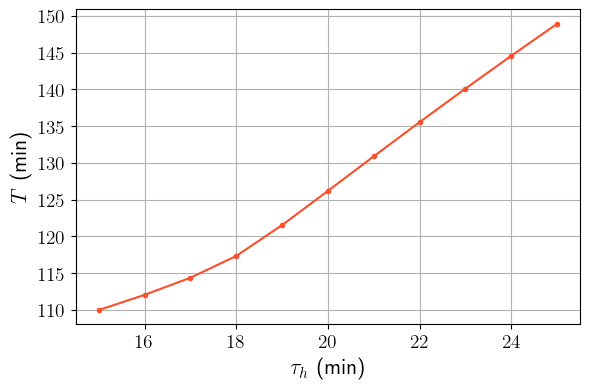

In [8]:
plt.figure(figsize=(6, 4))

plt.plot(hes_delays, periods_uncoupled, marker='.', linestyle='-', color=hescolor2)
plt.xlabel(r'$\tau_h$ (min)', fontsize=16)
plt.ylabel(r'$T$ (min)', fontsize=16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig('single_cell_hes_periods.png', dpi=600)

## Plot two example oscillations

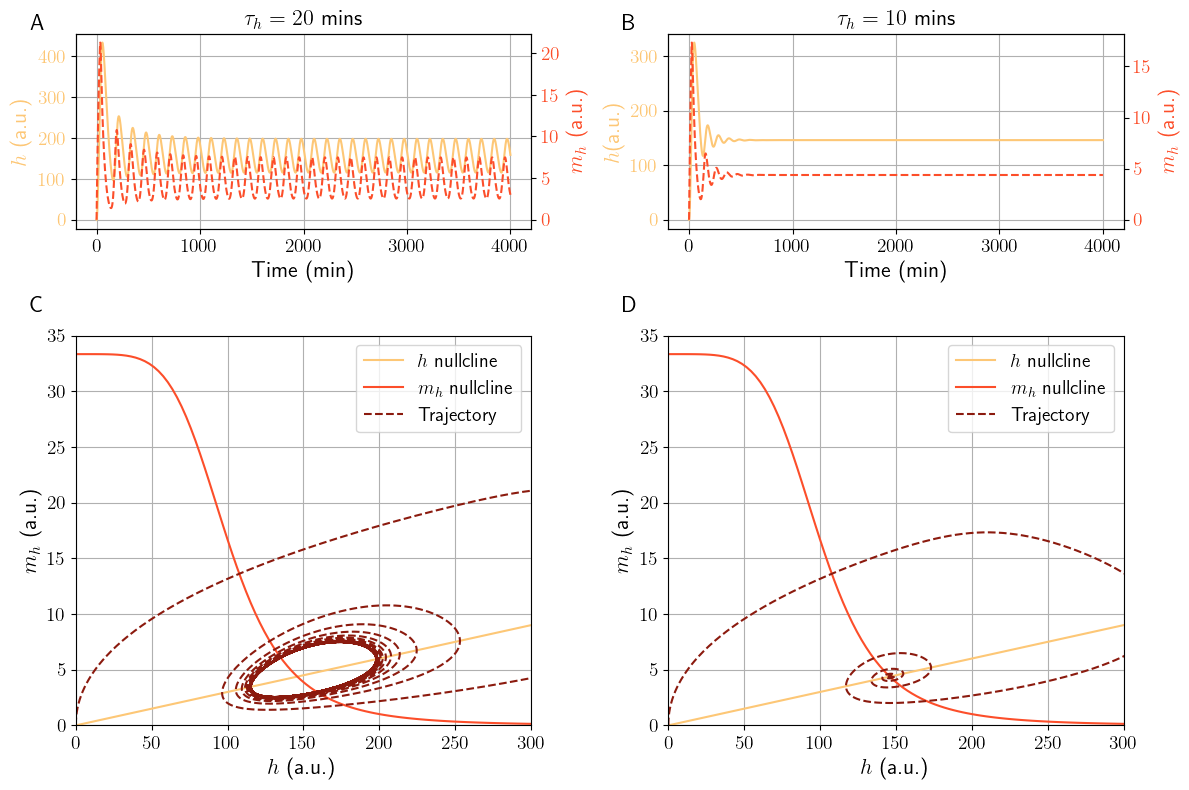

In [6]:
fig = plt.figure(figsize=(12, 8))

# Create a 2x2 grid with custom height ratios
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2], figure=fig)

# --- Subplot 1 ---
ax1 = fig.add_subplot(gs[0, 0])
t = np.arange(0, num_tsteps * dt, dt)

# Primary y-axis (h)
ax1.plot(t, results_examples[1, :, 0], color=hescolor1, label=r'$h$')
ax1.set_xlabel(r'Time (min)', fontsize=16)
ax1.set_ylabel(r'$h$ (a.u.)', fontsize=16, color=hescolor1)
ax1.tick_params(axis='y', labelcolor=hescolor1)
ax1.grid()
ax1.set_title(r'$\tau_h = 20$ mins', fontsize=16)
ax1.tick_params(labelsize=14)

# Secondary y-axis (m_h)
ax1b = ax1.twinx()
ax1b.plot(t, results_examples[1, :, 1], color=hescolor2, linestyle='--', label=r'$m_h \cdot 10$')
ax1b.set_ylabel(r'$m_h$ (a.u.)', fontsize=16, color=hescolor2)
ax1b.tick_params(axis='y', labelcolor=hescolor2)
ax1b.tick_params(labelsize=14)

# --- Subplot 2 ---
ax2 = fig.add_subplot(gs[0, 1])
# Primary y-axis (h)
ax2.plot(t, results_examples[0, :, 0], color=hescolor1, label=r'$h$')
ax2.set_xlabel(r'Time (min)', fontsize=16)
ax2.set_ylabel(r'$h$(a.u.)', fontsize=16, color=hescolor1)
ax2.tick_params(axis='y', labelcolor=hescolor1)
ax2.grid()
ax2.set_title(r'$\tau_h = 10$ mins', fontsize=16)
ax2.tick_params(labelsize=14)

# Secondary y-axis (m_h)
ax2b = ax2.twinx()
ax2b.plot(t, results_examples[0, :, 1], color=hescolor2, linestyle='--', label=r'$m_h \cdot 10$')
ax2b.set_ylabel(r'$m_h $ (a.u.)', fontsize=16, color=hescolor2)
ax2b.tick_params(axis='y', labelcolor=hescolor2)
ax2b.tick_params(labelsize=14)

# Bottom-left (wider)
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(h_null_plot, m_h_plot,  label=r'$h$ nullcline', color = hescolor1)
ax3.plot(h_plot, m_h_null_plot,  label=r'$m_h$ nullcline', color = hescolor2)
ax3.plot(results_examples[1, :, 0], results_examples[1, :, 1], ls = '--', label = 'Trajectory', color = hescolor3)
ax3.set_xlabel(r'$h$ (a.u.)', fontsize=16)
ax3.set_ylabel(r'$m_h$ (a.u.)', fontsize=16)
ax3.set_xlim(0, 300)
ax3.set_ylim(0, 35)
ax3.grid()
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.legend(fontsize=14)

# Bottom-right (wider)
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(h_null_plot, m_h_plot,  label=r'$h$ nullcline', color = hescolor1)
ax4.plot(h_plot, m_h_null_plot,  label=r'$m_h$ nullcline', color = hescolor2)
ax4.plot(results_examples[0, :, 0], results_examples[0,:,1], color=hescolor3, ls = '--', label = 'Trajectory')
ax4.set_xlabel(r'$h$ (a.u.)', fontsize=16)
ax4.set_ylabel(r'$m_h$ (a.u.)', fontsize=16)
ax4.set_xlim(0, 300)
ax4.set_ylim(0, 35)
ax4.grid()
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.legend(fontsize=14)

# Add subplot letters
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
ax4.text(-0.1, 1.1, 'D', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')


plt.tight_layout()
# plt.savefig('single_cell_examples.png', dpi=600)

namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=50, T_h=array([0., 0.]), T_coupling=array([0., 0.]), w_h=1, w_coupling=0, l=5, n=3, grad_hes=False, grad_coup=False, grad_hes_strength=0, grad_coup_strength=0, T_h_steps=array([100, 100]), T_coup_steps=array([0, 0]))
meshgrid shapes: (25, 25) (25, 25)
(25, 25)
(25, 25)


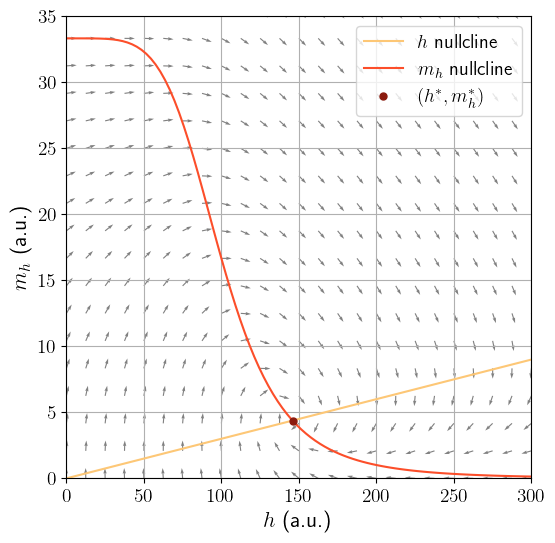

In [17]:
h = np.linspace(0, 300, 25)
m = np.linspace(0, 50, 25)
# h_null_plot, m_h_null_plot = nullclines_Hes(m_h_plot, h_plot, p_h, l, gamma_h, gamma_m)

params.T_h = np.zeros_like(params.T_h)  # Set T_h to zero for the vector field
print(params)
H, M = np.meshgrid(h, m)
print('meshgrid shapes:', H.shape, M.shape) 

# Define vector field components (U, V)
U = dh_dt(H, M, params) # x-component of vectors
print(U.shape)
V = dmh_dt(M, H, 0, params, lattice) /gamma_m # y-component of vectors
print(V.shape)

# Normalize the vectors to unit magnitude
magnitude = np.sqrt(U**2 + V**2)
# Avoid division by zero
magnitude[magnitude == 0] = 1  
U_normalized = U / magnitude
V_normalized = V / magnitude

# Create the plot
plt.figure(figsize=(6, 6))
plt.quiver(H, M, U_normalized, V_normalized, color='gray')
plt.plot(h_null_plot, m_h_plot,  label=r'$h$ nullcline', color = hescolor1)
plt.plot(h_plot, m_h_null_plot,  label=r'$m_h$ nullcline', color = hescolor2)
plt.plot(x_fixed, y_fixed, marker = 'o', ls = 'None', color = hescolor3, label=r'$(h^*, m_h^*)$', markersize=5)
plt.xlabel(r'$h$ (a.u.)', fontsize=16)
plt.ylabel(r'$m_h$ (a.u.)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.xlim(0, 300)
plt.ylim(0, 35)
plt.grid(True)
# plt.savefig('single-cell-stability-vector-field.png', dpi=600)
plt.show()